In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.cluster import KMeans
import numpy as np

import os
import json
import pandas as pd
import collections
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob

In [3]:
def box_corner_to_center(boxes):
    """
    boxes: (num_boxes, x1, y1, x2, y2)
    where (x1,y1) is the upper corner left coordinate
    and   (x2, y2) is the bottom corner right coo
    """
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

def draw_bbox(image, coords):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    x_min, x_max, y_min, y_max = coords
    rect = plt.Rectangle((x_min * 256.0, y_min * 256.0), 
                         x_max * 256.0 - x_min * 256.0, 
                         y_max * 256.0 - y_min * 256.0, 
                         linewidth=3, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [4]:
class CreateAnchorBoxes:
    """
    Takes image scale size to generate coordinates of all anchor boxes given ratios and sizes.
    
    image: (batch_size, channel, width, height)
    sizes: 1D list
    ratios: 1D list
    """
    def __init__(self, image, sizes, ratios):
        self.image_height, self.image_width = image.shape[-2], image.shape[-1]
        self.sizes = torch.tensor(sizes, device='cuda')
        self.ratios = torch.tensor(ratios, device='cuda')
        self.num_boxes = len(sizes) * len(ratios)
        self.create_grid_center_points()
        self.create_anchor_width_height()

    def create_grid_center_points(self):
        self.center_x_axis = (torch.arange(self.image_width, device='cuda') + 0.5) / self.image_width
        self.center_y_axis = (torch.arange(self.image_height, device='cuda') + 0.5) / self.image_height
        self.grid_x_coords, self.grid_y_coords = torch.meshgrid(self.center_x_axis, self.center_y_axis)
        self.grid_x_coords = self.grid_x_coords.reshape(-1)
        self.grid_y_coords = self.grid_y_coords.reshape(-1)

    def create_anchor_width_height(self):
        width_anchor = torch.tensor([], device='cuda')
        height_anchor = torch.tensor([], device='cuda')

        for size in self.sizes:
            for ratio in self.ratios:
                width_anchor = torch.cat((width_anchor, size * torch.sqrt(ratio).unsqueeze(0)))
                height_anchor = torch.cat((height_anchor, size / torch.sqrt(ratio).unsqueeze(0)))

        self.grid_width_height = torch.stack(
            (-width_anchor, -height_anchor,
             width_anchor, height_anchor)
        ).T.repeat(self.image_height * self.image_width, 1) / 2

    def mapping(self):
        out_grid = torch.stack(
            [self.grid_x_coords, self.grid_y_coords,
             self.grid_x_coords, self.grid_y_coords],
            dim=1).repeat_interleave(self.num_boxes, dim=0)
        return out_grid + self.grid_width_height
    
    
def multibox_prior(data, sizes, ratios):
    # Get height and width of the input tensor
    in_height, in_width = data.shape[-2:]

    # Determine device and other relevant constants
    device = data.device
    num_sizes, num_ratios = len(sizes), len(ratios)
    boxes_per_pixel = num_sizes + num_ratios - 1

    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    offset_h, offset_w = 0.5, 0.5
    steps_h, steps_w = 1.0 / in_height, 1.0 / in_width

    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Compute anchor box widths and heights
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:]))) * in_height / in_width
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))

    # Create anchor box manipulations
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2

    # Generate the grid of shifts
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations

    return output.unsqueeze(0)

In [5]:
def calculate_box_area(boxes):
    return ((boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])).cuda()

def BoxIou(boxes1, boxes2):
    boxes1 = boxes1.cuda()
    boxes2 = boxes2.cuda()

    areas1 = calculate_box_area(boxes1)
    areas2 = calculate_box_area(boxes2)

    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)

    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas


def assign_anchor_to_bbox(ground_truth, anchors, iou_threshold=0.5):
    
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    jaccard = BoxIou(anchors, ground_truth)

    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long, device="cuda")

    max_ious, indices = torch.max(jaccard, dim=1)
    if isinstance(iou_threshold, float):
        iou_threshold = torch.tensor(iou_threshold, device=max_ious.device)
        
    anc_i = torch.nonzero(max_ious >= iou_threshold, as_tuple=False).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j

    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
        
    return anchors_bbox_map

In [6]:
def offset_boxes(anchors, assigned_bboxes, sigma_xy=0.1, sigma_wh=0.2, mean=0, eps=1e-6):
    center_anchors = box_corner_to_center(anchors.cuda())
    center_assigned_bboxes = box_corner_to_center(assigned_bboxes.cuda())
    offset_xy = ((center_assigned_bboxes[:, :2] - center_anchors[:, :2]) / center_anchors[:, 2:] - mean) / sigma_xy
    offset_wh = (torch.log(eps + center_assigned_bboxes[:, 2:] / center_anchors[:, 2:] - mean)) / sigma_wh
    offset = torch.cat([offset_xy, offset_wh], dim=1)
    return offset


def multibox_target(anchors, labels):
    """Label anchor boxes using ground-truth bounding boxes."""
    
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)

        class_labels = torch.zeros(num_anchors, dtype=torch.long, device="cuda")
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32, device="cuda")

        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]

        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
        
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

### **Backbone**

In [7]:
from urllib.request import urlopen
import timm

In [8]:
base = timm.create_model('xcit_tiny_24_p16_384.fb_dist_in1k', pretrained=True)
data_config = timm.data.resolve_model_data_config(base)
data_config

{'input_size': (3, 384, 384),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 1.0,
 'crop_mode': 'center'}

In [9]:
transforms = timm.data.create_transform(**data_config, is_training=False)
transforms

Compose(
    Resize(size=384, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(384, 384))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [20]:
base.blocks

ModuleList(
  (0-23): 24 x XCABlock(
    (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
    (attn): XCA(
      (qkv): Linear(in_features=192, out_features=576, bias=True)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=192, out_features=192, bias=True)
      (proj_drop): Dropout(p=0.0, inplace=False)
    )
    (drop_path): Identity()
    (norm3): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
    (local_mp): LPI(
      (conv1): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=192)
      (act): GELU(approximate='none')
      (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=192)
    )
    (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
    (mlp): Mlp(
      (fc1): Linear(in_features=192, out_features=768, bias=True)
      (act): GELU(approximate='none')
      (drop1

In [26]:
x = Image.open("../dataset/Car/ds/img/Cars10.png").convert("RGB")
output = base.forward_intermediates(transforms(x).unsqueeze(0), intermediates_only=True, indices=[23])

for o in output:
    print(o.shape)

torch.Size([1, 192, 24, 24])


In [72]:

# We have 5 scales
depths = [192, 192, 192, 192, 192]
width =  [24, 12,   6,   3,   1]
height = [24, 12,   6,   3,   1]


X_multiscale = [
    torch.randn(1, depths[0], width[0], height[0]),
    torch.randn(1, depths[1], width[1], height[1]),
    torch.randn(1, depths[2], width[2], height[2]),
    torch.randn(1, depths[3], width[3], height[3]),
    torch.randn(1, depths[4], width[4], height[4]),
]

sizes = [[0.2,  0.272], 
         [0.37, 0.447], 
         [0.54, 0.619], 
         [0.71, 0.79], 
         [0.88, 0.961]]

ratios = [[1, 2, 0.5],
          [1, 2, 0.5],
          [1, 2, 0.5],
          [1, 2, 0.5],
          [1, 2, 0.5]]

num_anchors_per_pixel = len(sizes[0]) * len(ratios[0])
print(f"Each group (pixel) has {num_anchors_per_pixel} anchor boxes")

Each group (pixel) has 6 anchor boxes


### **K-means for sizes**

In [55]:
json_files = glob("../dataset/Car/ds/ann/*.json")

data = []
for file in json_files:
    with open(file, 'r') as f:
        # Load the JSON data
        content = json.load(f)
        
        # Extract the relevant information from the JSON
        for obj in content['objects']:
            obj_id = obj['id']
            x_min = obj['points']['exterior'][0][0]
            y_min = obj['points']['exterior'][0][1]
            x_max = obj['points']['exterior'][1][0]
            y_max = obj['points']['exterior'][1][1]
            width = content['size']['width']
            height = content['size']['height']
            
            # Append the data to the list
            data.append({
                'id': obj_id,
                'name': os.path.basename(file)[:-5],
                'class': 0,
                'x_min': x_min,
                'x_max': x_max,
                'y_min': y_min,
                'y_max': y_max,
                'width': width,
                'height': height
            })


df = pd.DataFrame(data)
df.to_csv("../dataset/Car/ds/meta.csv", index=False)
df

,id,name,class,x_min,x_max,y_min,y_max,width,height
0,6325281,Cars0.png,0,226,419,125,173,500,268
1,6325304,Cars1.png,0,134,262,128,160,400,248
2,6325367,Cars10.png,0,140,303,5,148,400,225
3,6325292,Cars100.png,0,175,214,114,131,400,267
4,6325320,Cars101.png,0,167,240,202,220,400,300
...,...,...,...,...,...,...,...,...,...
466,6325238,Cars95.png,0,278,407,182,263,600,400
467,6325206,Cars96.png,0,133,261,126,160,400,248
468,6325194,Cars97.png,0,98,297,102,191,400,300
469,6325459,Cars98.png,0,85,247,196,259,370,400


In [56]:
df = pd.read_csv("../dataset/Car/ds/meta.csv")
df

,id,name,class,x_min,x_max,y_min,y_max,width,height
0,6325281,Cars0.png,0,226,419,125,173,500,268
1,6325304,Cars1.png,0,134,262,128,160,400,248
2,6325367,Cars10.png,0,140,303,5,148,400,225
3,6325292,Cars100.png,0,175,214,114,131,400,267
4,6325320,Cars101.png,0,167,240,202,220,400,300
...,...,...,...,...,...,...,...,...,...
466,6325238,Cars95.png,0,278,407,182,263,600,400
467,6325206,Cars96.png,0,133,261,126,160,400,248
468,6325194,Cars97.png,0,98,297,102,191,400,300
469,6325459,Cars98.png,0,85,247,196,259,370,400


### **Visualization of distribution**

In [57]:
def change_to_wh(data):
    data['w'] = data['x_max'] - data['x_min'] + 1
    data['h'] = data['y_max'] - data['y_min'] + 1
    return data

data = change_to_wh(df)
data

,id,name,class,x_min,x_max,y_min,y_max,width,height,w,h
0,6325281,Cars0.png,0,226,419,125,173,500,268,194,49
1,6325304,Cars1.png,0,134,262,128,160,400,248,129,33
2,6325367,Cars10.png,0,140,303,5,148,400,225,164,144
3,6325292,Cars100.png,0,175,214,114,131,400,267,40,18
4,6325320,Cars101.png,0,167,240,202,220,400,300,74,19
...,...,...,...,...,...,...,...,...,...,...,...
466,6325238,Cars95.png,0,278,407,182,263,600,400,130,82
467,6325206,Cars96.png,0,133,261,126,160,400,248,129,35
468,6325194,Cars97.png,0,98,297,102,191,400,300,200,90
469,6325459,Cars98.png,0,85,247,196,259,370,400,163,64


In [58]:
def compute_new_static_size(width, height, min_dim, max_dim):
    orig_height = height
    orig_width = width
    orig_min_dim = min(orig_height, orig_width)
    
    # Calculate the larger of possible sizes
    large_scale_factor = min_dim / float(orig_min_dim)
    large_height = int(round(orig_height * large_scale_factor))
    large_width = int(round(orig_width * large_scale_factor))
    large_size = [large_height, large_width]
    
    if max_dim:
        orig_max_dim = max(orig_height, orig_width)
        small_scale_factor = max_dim / float(orig_max_dim)
        small_height = int(round(orig_height * small_scale_factor))
        small_width = int(round(orig_width * small_scale_factor))
        small_size = [small_height, small_width]
        new_size = large_size
        
    if max(large_size) > max_dim:
        new_size = small_size
    else:
        new_size = large_size
    
    return new_size[1], new_size[0]

In [59]:
min_dim = 600
max_dim = 1024

data['new_w'], data['new_h'] = np.vectorize(compute_new_static_size)(data['width'],  data['height'], min_dim, max_dim)
data

,id,name,class,x_min,x_max,y_min,y_max,width,height,w,h,new_w,new_h
0,6325281,Cars0.png,0,226,419,125,173,500,268,194,49,1024,549
1,6325304,Cars1.png,0,134,262,128,160,400,248,129,33,968,600
2,6325367,Cars10.png,0,140,303,5,148,400,225,164,144,1024,576
3,6325292,Cars100.png,0,175,214,114,131,400,267,40,18,899,600
4,6325320,Cars101.png,0,167,240,202,220,400,300,74,19,800,600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,6325238,Cars95.png,0,278,407,182,263,600,400,130,82,900,600
467,6325206,Cars96.png,0,133,261,126,160,400,248,129,35,968,600
468,6325194,Cars97.png,0,98,297,102,191,400,300,200,90,800,600
469,6325459,Cars98.png,0,85,247,196,259,370,400,163,64,600,649


In [60]:
data['b_w'] = data['new_w'] * data['w']/ data['width']
data['b_h'] = data['new_h'] * data['h'] / data['height']
data['b_ar'] = data['b_w'] / data['b_h']
data

,id,name,class,x_min,x_max,y_min,y_max,width,height,w,h,new_w,new_h,b_w,b_h,b_ar
0,6325281,Cars0.png,0,226,419,125,173,500,268,194,49,1024,549,397.312000,100.376866,3.958203
1,6325304,Cars1.png,0,134,262,128,160,400,248,129,33,968,600,312.180000,79.838710,3.910133
2,6325367,Cars10.png,0,140,303,5,148,400,225,164,144,1024,576,419.840000,368.640000,1.138889
3,6325292,Cars100.png,0,175,214,114,131,400,267,40,18,899,600,89.900000,40.449438,2.222528
4,6325320,Cars101.png,0,167,240,202,220,400,300,74,19,800,600,148.000000,38.000000,3.894737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,6325238,Cars95.png,0,278,407,182,263,600,400,130,82,900,600,195.000000,123.000000,1.585366
467,6325206,Cars96.png,0,133,261,126,160,400,248,129,35,968,600,312.180000,84.677419,3.686697
468,6325194,Cars97.png,0,98,297,102,191,400,300,200,90,800,600,400.000000,180.000000,2.222222
469,6325459,Cars98.png,0,85,247,196,259,370,400,163,64,600,649,264.324324,103.840000,2.545496


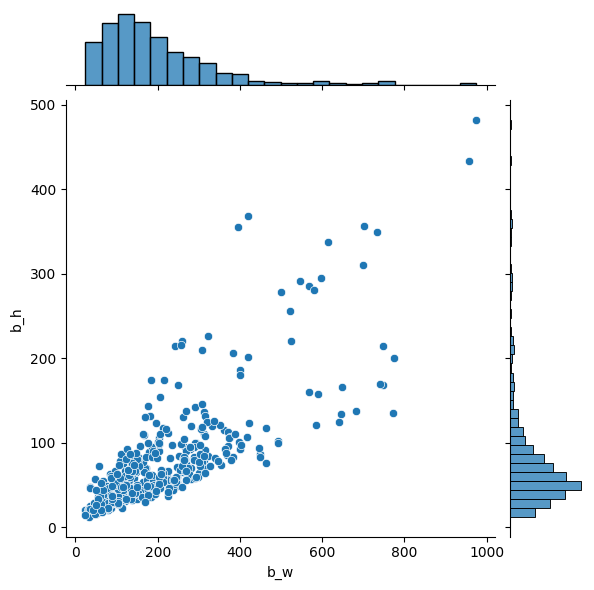

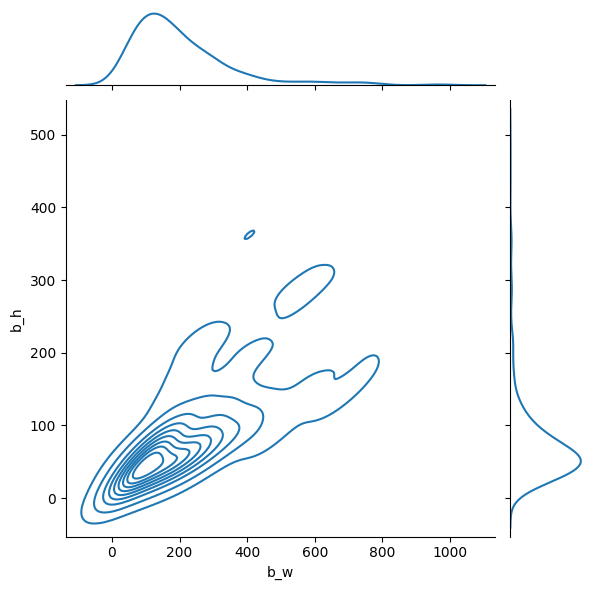

In [63]:
sns.jointplot(x="b_w", y="b_h", data=data)
sns.jointplot(x="b_w", y="b_h", data=data, kind='kde')

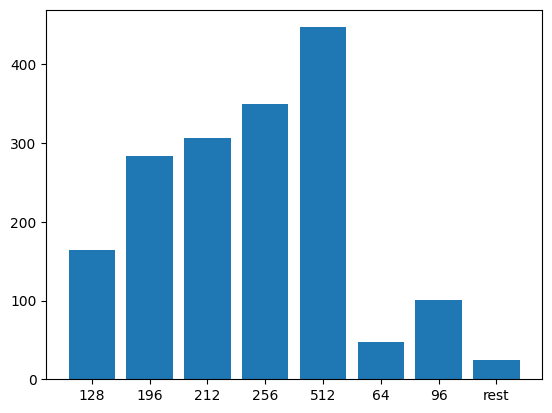

In [66]:
def count_base_size(width, height, input_array=[64, 96, 128, 196, 212, 256, 512]):
    result = {}
    for ele in input_array:
        result[str(ele)] = 0
    result['rest'] = 0
    
    for w, h in zip(width, height):
        done = False
        for inp in input_array:
            if w <= inp and h <= inp:
                result[str(inp)] += 1
                done = True
        if done == False:
            result['rest'] += 1
            
    return result
    
D = count_base_size(data["b_w"].tolist(), data["b_h"].tolist())
OD = collections.OrderedDict(sorted(D.items()))
plt.bar(range(len(OD)), OD.values(), align='center')
plt.xticks(range(len(OD)), OD.keys())
plt.show()

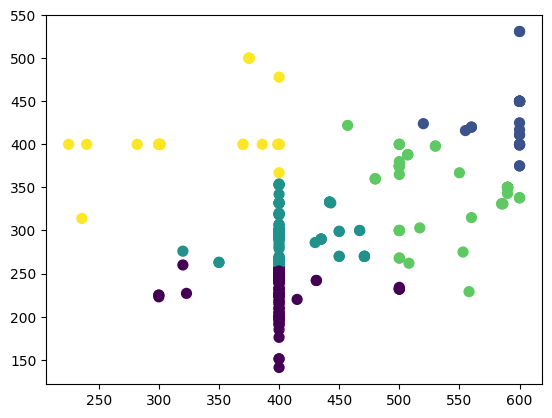

In [71]:
X = data[['width', 'height']].values
K = KMeans(5, random_state=0)
labels = K.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=labels.labels_, s=50, cmap='viridis')

In [70]:
out = labels.cluster_centers_
ar = out[:,0] / out[:,1]
scale = out[:,1] * np.sqrt(ar) / 256

print("Aspect Ratios: {}".format(ar))
print("Scales: {}".format(scale))

Aspect Ratios: [2.97559732 2.18475694 3.09312127 3.07672499 2.20616235]
Scales: [0.46120287 0.25434905 1.66011094 0.74415225 1.38287188]


### **IOU-based clustering**

In [ ]:
def iou(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_


def avg_iou(boxes, clusters):
    """
    Calculates the average Intersection over Union (IoU) between a numpy array of boxes and k clusters.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: average IoU as a single float
    """
    return np.mean([np.max(iou(boxes[i], clusters)) for i in range(boxes.shape[0])])


def translate_boxes(boxes):
    """
    Translates all the boxes to the origin.
    :param boxes: numpy array of shape (r, 4)
    :return: numpy array of shape (r, 2)
    """
    new_boxes = boxes.copy()
    for row in range(new_boxes.shape[0]):
        new_boxes[row][2] = np.abs(new_boxes[row][2] - new_boxes[row][0])
        new_boxes[row][3] = np.abs(new_boxes[row][3] - new_boxes[row][1])
    return np.delete(new_boxes, [0, 1], axis=1)


def kmeans(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

In [ ]:
def prepare_anchor_boxes(X_multiscale, sizes, ratios, num_anchors_per_pixel):
    
    anchors_multiscale = []

    for i in range(len(X_multiscale)):

        anchors = multibox_prior(X_multiscale[i], sizes[i], ratios[i])
        anchors_multiscale.append(anchors)
        
        total_anchors = X_multiscale[i].shape[2] * X_multiscale[i].shape[3] * num_anchors_per_pixel
        print(f"Total anchor boxes are: {total_anchors} -> anchor shape: {anchors.shape}")
        
    anchors_multiscale = torch.cat(anchors_multiscale, dim=1)
    return anchors_multiscale
        
anchors_multiscale = prepare_anchor_boxes(X_multiscale, sizes, ratios, num_anchors_per_pixel)
print(anchors_multiscale.shape)